In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
company = 'Tata Motors'
stock_data = pd.read_csv("/content/Tata Motors_30-Years.csv", parse_dates=['Date'], sep=',', index_col='Date')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
03-01-1994,43.116882,44.314575,43.116882,43.715729,31.477283,0.0
04-01-1994,44.314575,45.362556,44.314575,44.613998,32.124084,0.0
05-01-1994,43.715729,44.613998,43.715729,44.015152,31.692881,0.0
06-01-1994,44.314575,46.410534,43.865440,46.111111,33.202068,0.0
07-01-1994,48.506496,50.003609,47.907650,49.704185,35.789234,0.0
...,...,...,...,...,...,...
24-04-2024,992.400024,995.900024,988.000000,991.650024,991.650024,4671450.0
25-04-2024,992.500000,1003.299988,989.500000,1001.250000,1001.250000,8366455.0
26-04-2024,1007.799988,1008.950012,996.599976,999.500000,999.500000,7937500.0


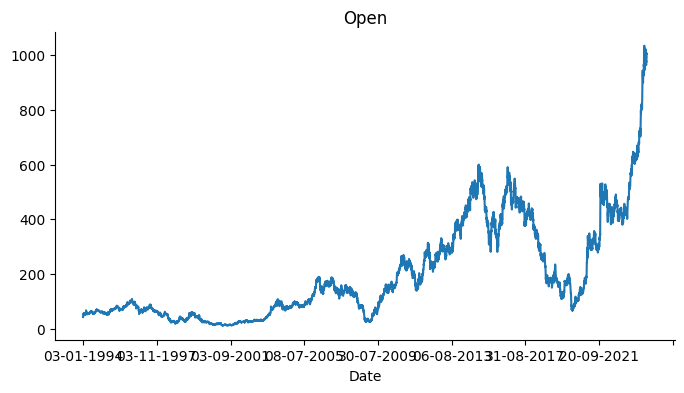

In [5]:
# @title Open

from matplotlib import pyplot as plt
stock_data['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.,  9000.]),
 [Text(-1000.0, 0, '20-04-2020'),
  Text(0.0, 0, '03-01-1994'),
  Text(1000.0, 0, '03-11-1997'),
  Text(2000.0, 0, '03-09-2001'),
  Text(3000.0, 0, '08-07-2005'),
  Text(4000.0, 0, '30-07-2009'),
  Text(5000.0, 0, '06-08-2013'),
  Text(6000.0, 0, '31-08-2017'),
  Text(7000.0, 0, '20-09-2021'),
  Text(8000.0, 0, ''),
  Text(9000.0, 0, '')])

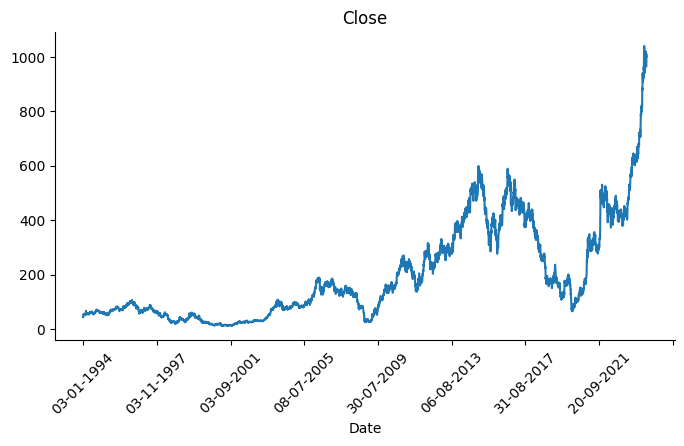

In [46]:
# @title Close

from matplotlib import pyplot as plt
stock_data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation=45)

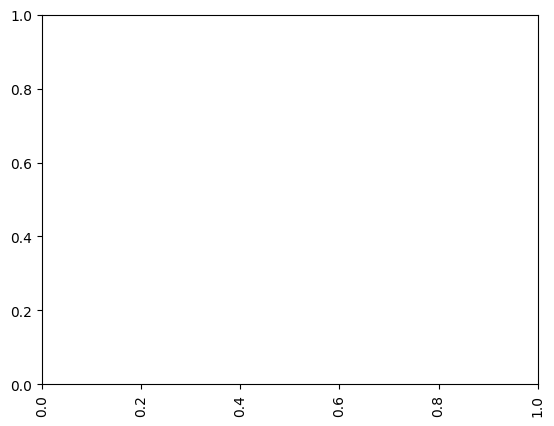

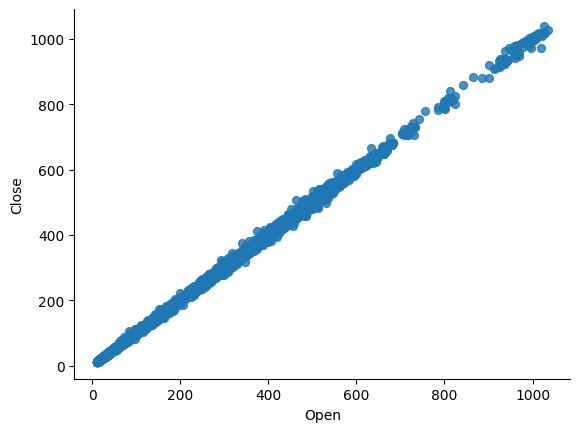

In [48]:
plt.xticks(rotation=90)# @title Open vs Close

from matplotlib import pyplot as plt
stock_data.plot(kind='scatter', x='Open', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
import plotly.express as px

# Assuming you have your data in a pandas DataFrame called 'stock_data'
df_close = stock_data['Close']

# Create a line plot using Plotly Express
fig = px.line(stock_data, x=stock_data.index, y='Close', title='Tata Motors stock closing price',color_discrete_sequence=['red'])

# Update the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Closing Prices',
    plot_bgcolor='rgba(255, 255, 255, 0.9)',  # Set the background color to light gray (90% opacity)
    paper_bgcolor='rgba(240, 240, 240, 0.9)'  # Set the plot area color to light gray (90% opacity)
)

# Show the plot
fig.show()

In [9]:
import plotly.graph_objs as go

def test_stationarity(timeseries):
    """
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    """
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Create traces for the original timeseries, rolling mean, and rolling std
    trace1 = go.Scatter(x=timeseries.index, y=timeseries.values, mode='lines', name='Original')
    trace2 = go.Scatter(x=rolmean.index, y=rolmean.values, mode='lines', name='Rolling Mean')
    trace3 = go.Scatter(x=rolstd.index, y=rolstd.values, mode='lines', name='Rolling Std')

    # Create a data array with the traces
    data = [trace1, trace2, trace3]

    # Define the layout
    layout = go.Layout(
        title='Rolling Mean & Standard Deviation',
        xaxis_title='Date',
        yaxis_title='Value',
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(0,0,0,0)'),
        plot_bgcolor='rgba(255,255,255,0.9)',
        paper_bgcolor='rgba(240,240,240,0.9)'
    )

    # Create the figure
    fig = go.Figure(data=data, layout=layout)

    # Display the figure
    fig.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
test_stationarity(df_close.head(2000))

Results of Dickey-Fuller Test:
Test Statistic                   -0.785580
p-value                           0.823321
#Lags Used                        7.000000
Number of Observations Used    1992.000000
Critical Value (1%)              -3.433637
Critical Value (5%)              -2.862992
Critical Value (10%)             -2.567543
dtype: float64


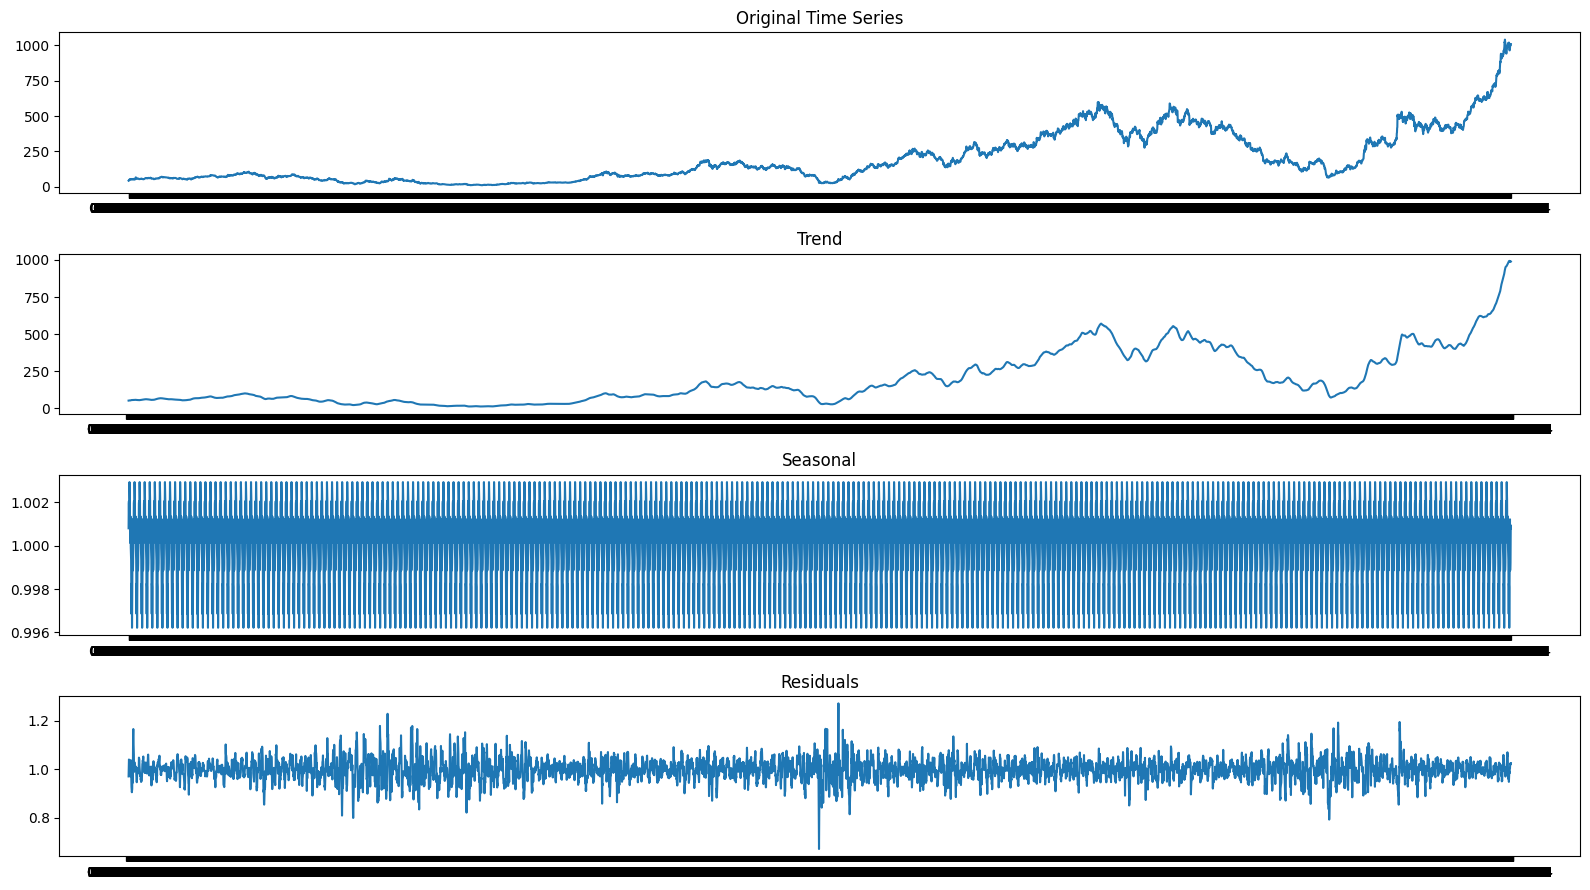

In [11]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Interpolate missing values in df_close
df_close = df_close.interpolate()

plt.style.use('default')
result = seasonal_decompose(df_close, model='multiplicative', period=28)

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(16, 9))

# Plot the original time series
axs[0].plot(df_close)
axs[0].set_title('Original Time Series')

# Plot the trend component
axs[1].plot(result.trend)
axs[1].set_title('Trend')

# Plot the seasonal component
axs[2].plot(result.seasonal)
axs[2].set_title('Seasonal')

# Plot the residual component
axs[3].plot(result.resid)
axs[3].set_title('Residuals')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Transformed data')

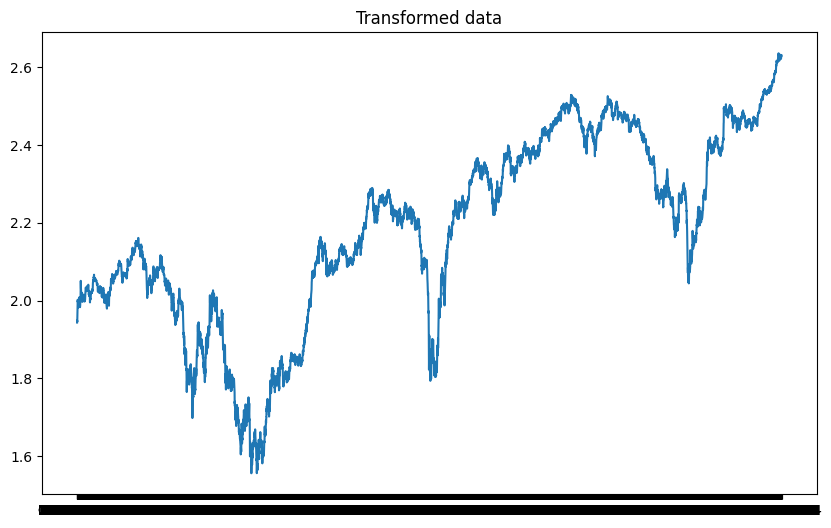

In [12]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

In [13]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

Results of Dickey-Fuller Test:
Test Statistic                  -25.586611
p-value                           0.000000
#Lags Used                        9.000000
Number of Observations Used    7634.000000
Critical Value (1%)              -3.431207
Critical Value (5%)              -2.861919
Critical Value (10%)             -2.566972
dtype: float64


<Figure size 1000x600 with 0 Axes>

In [14]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [15]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [16]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

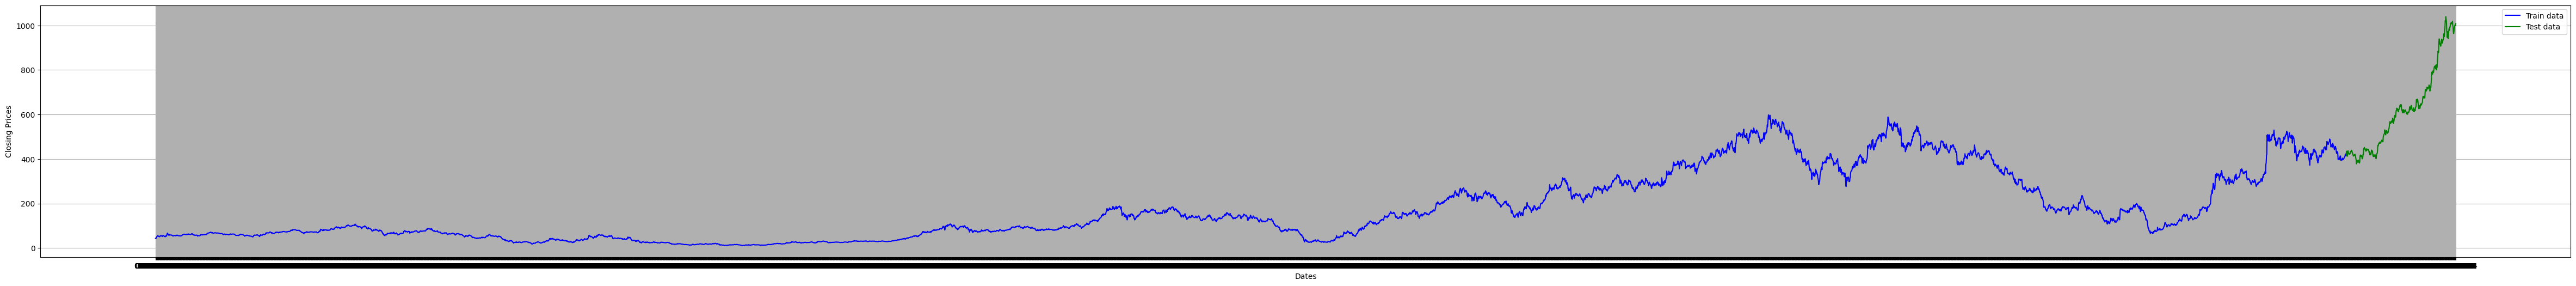

In [17]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(60,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [18]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [19]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
226/226 [==============================] - 9s 31ms/step - loss: 4.9081e-05 - mean_absolute_error: 0.0049
Epoch 2/15
226/226 [==============================] - 5s 23ms/step - loss: 4.7450e-05 - mean_absolute_error: 0.0048
Epoch 3/15
226/226 [==============================] - 6s 28ms/step - loss: 4.7314e-05 - mean_absolute_error: 0.0048
Epoch 4/15
226/226 [==============================] - 6s 25ms/step - loss: 4.6962e-05 - mean_absolute_error: 0.0048
Epoch 5/15
226/226 [==============================] - 5s 23ms/step - loss: 4.7112e-05 - mean_absolute_error: 0.0048
Epoch 6/15
226/226 [==============================] - 7s 31ms/step - loss: 4.6960e-05 - mean_absolute_error: 0.0048
Epoch 7/15
226/226 [==============================] - 5s 23ms/step - loss: 4.6959e-05 - mean_absolute_error: 0.0048
Epoch 8/15
226/226 [==============================] - 7s 30ms/step - loss: 4.6932e-05 - mean_absolute_error: 0.0048
Epoch 9/15
226/226 [==============================] - 6s 24ms/step - los

In [21]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 1s 9ms/step - loss: 9.4205e-06 - mean_absolute_error: 0.0024
Test MSE: 9.420514288649429e-06
Test MAE: 0.002371855080127716


In [77]:
import chart_studio.plotly as py
import plotly.graph_objects as go

# Assuming you have already imported necessary libraries and defined variables like y_pred, test_original, test_days, df_close_tf, np, company

pred_data = pd.DataFrame(y_pred[:,0], index=test_original.index, columns=['Close'])
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

fig = go.Figure()

fig.add_trace(go.Scatter(x=test_original.index, y=test_original, mode='lines', name='Actual prices', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=pred_data.index, y=pred_data['Close'], mode='lines', name='Predicted prices', line=dict(color='orange')))

fig.update_layout(title=company + ' Stock Price', xaxis_title='Dates', yaxis_title='Closing Prices', showlegend=True, template='plotly_dark')
fig.update_xaxes(tickangle=45)

py.iplot(fig)

In [72]:
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go

username = 'mustafa2303'
api_key = 'KoAzCzKXBbh23qkRYJXc'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

fig = go.Figure()

fig.add_trace(go.Scatter(x=train_original.index, y=train_original, mode='lines', name='Train data', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test_original.index, y=test_original, mode='lines', name='Test data', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test_original.index, y=pred_data, mode='lines', name='Prediction', line=dict(color='red')))

fig.update_layout(title=company + ' Stock Price (Last 2 Years)', xaxis_title='Dates', yaxis_title='Closing Prices', showlegend=True, template='plotly_dark')

py.iplot(fig)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have defined your model and loaded your data

# Compile your model
model.compile(optimizer='adam', loss='mse')

# Train your model and store the training history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X, y))

# Access train and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print train and validation loss
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}: Train Loss: {train_loss[epoch]}, Validation Loss: {val_loss[epoch]}")


Epoch 1/10
226/226 [==============================] - 10s 36ms/step - loss: 4.6827e-05 - val_loss: 4.4464e-05
Epoch 2/10
226/226 [==============================] - 8s 37ms/step - loss: 4.7040e-05 - val_loss: 4.8571e-05
Epoch 3/10
226/226 [==============================] - 11s 49ms/step - loss: 4.6671e-05 - val_loss: 4.5229e-05
Epoch 4/10
226/226 [==============================] - 7s 32ms/step - loss: 4.7188e-05 - val_loss: 4.4879e-05
Epoch 5/10
226/226 [==============================] - 9s 40ms/step - loss: 4.6773e-05 - val_loss: 4.4455e-05
Epoch 6/10
226/226 [==============================] - 8s 35ms/step - loss: 4.6761e-05 - val_loss: 4.4850e-05
Epoch 7/10
226/226 [==============================] - 10s 42ms/step - loss: 4.6673e-05 - val_loss: 4.6920e-05
Epoch 8/10
226/226 [==============================] - 9s 40ms/step - loss: 4.6856e-05 - val_loss: 4.5658e-05
Epoch 9/10
226/226 [==============================] - 12s 55ms/step - loss: 4.7255e-05 - val_loss: 4.4949e-05
Epoch 10/10
226

In [79]:
import chart_studio.plotly as py
import plotly.graph_objects as go

# Assuming you have recorded the training and validation loss values during training in lists train_loss and val_loss
epochs = list(range(1, len(train_loss) + 1))

fig = go.Figure()

fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines', name='Training loss', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation loss', line=dict(color='red')))

fig.update_layout(title='Training and Validation Loss', xaxis_title='Epochs', yaxis_title='Loss', showlegend=True, template='plotly_dark')

py.iplot(fig)

In [33]:
import pandas as pd

# Assuming you have a list of predicted close prices called 'predicted_close_prices'
Prediction_Close = pred_data['Close']

# Create a DataFrame with the predicted close prices
df = pd.DataFrame({'Pred_Close_Price': Prediction_Close})

# Export the DataFrame to a CSV file
chunksize = 1000000  # Adjust this value based on your system's memory constraints
df.to_csv('predicted_close_prices.csv', index=False, mode='w', chunksize=chunksize)

In [80]:
import chart_studio.plotly as py
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=pred_data.index, y=pred_data['Close'], mode='lines', name='Predicted Close Price', line=dict(color='blue')))

fig.update_layout(title='Predicted Close Price', xaxis_title='Dates', yaxis_title='Close Price', template='plotly_dark')
fig.update_xaxes(tickangle=45)
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='gray')

py.iplot(fig)